# Logistic Regression for Grain Disease Recognition

## Data Preprocessing

In [1]:
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    f1_score,
    recall_score,
    precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from tqdm import tqdm
import joblib

In [2]:
GRAIN_TYPES = ["maize", "rice"]
MAIZE_CATEGORIES = ["0_NOR", "1_F&S", "2_SD", "3_MY", "4_AP", "5_BN", "6_HD", "7_IM"]
RICE_CATEGORIES = ["0_NOR", "1_F&S", "2_SD", "3_MY", "4_AP", "5_BN", "6_UN", "7_IM"]

We need to turn the pixels of the image into a feature vector to feed into the training model. We decided to use the HSV histogram as the embedding function to create the feature vector.

In [3]:
from logistic_regression_lib import collect_embeddings

## Train Logistic Regression Model

Collect embeddings from training images and train a logistic regression classifier. For now we combine the grain type and category in order to try and train a generalized model for both rice and maize.

In [4]:
# Collect training and test data
X_train_maize, y_train_maize = collect_embeddings("maize", "train")
X_train_rice, y_train_rice = collect_embeddings("rice", "train")

X_train = np.concatenate((X_train_maize, X_train_rice))
y_train = np.concatenate((y_train_maize, y_train_rice))
print(f"\nTraining data shape: {X_train.shape}")
print(f"Number of classes: {len(set(y_train))}")
print(f"Classes: {sorted(set(y_train))}")

Processing train images: 100%|██████████| 17100/17100 [01:27<00:00, 196.14it/s] 


Processing train images: 100%|██████████| 27862/27862 [00:37<00:00, 738.29it/s] 



Training data shape: (44962, 512)
Number of classes: 16
Classes: [np.str_('maize_0_NOR'), np.str_('maize_1_F&S'), np.str_('maize_2_SD'), np.str_('maize_3_MY'), np.str_('maize_4_AP'), np.str_('maize_5_BN'), np.str_('maize_6_HD'), np.str_('maize_7_IM'), np.str_('rice_0_NOR'), np.str_('rice_1_F&S'), np.str_('rice_2_SD'), np.str_('rice_3_MY'), np.str_('rice_4_AP'), np.str_('rice_5_BN'), np.str_('rice_6_UN'), np.str_('rice_7_IM')]


And lets encode the labels to integers for the logistic regression to work

In [5]:
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

print(f"Label encoding: {dict(enumerate(label_encoder.classes_))}")

Label encoding: {0: np.str_('maize_0_NOR'), 1: np.str_('maize_1_F&S'), 2: np.str_('maize_2_SD'), 3: np.str_('maize_3_MY'), 4: np.str_('maize_4_AP'), 5: np.str_('maize_5_BN'), 6: np.str_('maize_6_HD'), 7: np.str_('maize_7_IM'), 8: np.str_('rice_0_NOR'), 9: np.str_('rice_1_F&S'), 10: np.str_('rice_2_SD'), 11: np.str_('rice_3_MY'), 12: np.str_('rice_4_AP'), 13: np.str_('rice_5_BN'), 14: np.str_('rice_6_UN'), 15: np.str_('rice_7_IM')}


Finally let us train the logistic regression model

In [6]:
print(f"Training Logistic Regression model...")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train_encoded)

Training Logistic Regression model...


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

Let us save this model as a file

In [7]:
os.makedirs("models", exist_ok=True)

joblib.dump(lr_model, "models/logistic_regression.pkl")
joblib.dump(label_encoder, "models/label_encoder.pkl")

print(f"\nModel saved to models/logistic_regression.pkl")
print(f"Label encoder saved to models/label_encoder.pkl")


Model saved to models/logistic_regression.pkl
Label encoder saved to models/label_encoder.pkl


### Test the Trained Model

Let's test the model using the train set first to see its accuracy

In [8]:
train_accuracy = lr_model.score(X_train, y_train_encoded)
print(f"Training accuracy: {train_accuracy:.4f}")

Training accuracy: 0.7561


And then let's test the model on the test set

In [9]:
# Collect test data
X_test_maize, y_test_maize = collect_embeddings("maize", "test")
X_test_rice, y_test_rice = collect_embeddings("rice", "test")
X_test = np.concatenate((X_test_maize, X_test_rice))
y_test = np.concatenate((y_test_maize, y_test_rice))

print(f"Test data shape: {X_test.shape}")
print(f"Number of test classes: {len(set(y_test))}")
print(f"Test classes: {sorted(set(y_test))}")

# Encode test labels
y_test_encoded = label_encoder.transform(y_test)
print(f"\nTest set size: {X_test.shape[0]} samples")

Processing test images: 100%|██████████| 1900/1900 [00:09<00:00, 191.25it/s]


Processing test images: 100%|██████████| 3100/3100 [00:04<00:00, 705.32it/s]

Test data shape: (5000, 512)
Number of test classes: 16
Test classes: [np.str_('maize_0_NOR'), np.str_('maize_1_F&S'), np.str_('maize_2_SD'), np.str_('maize_3_MY'), np.str_('maize_4_AP'), np.str_('maize_5_BN'), np.str_('maize_6_HD'), np.str_('maize_7_IM'), np.str_('rice_0_NOR'), np.str_('rice_1_F&S'), np.str_('rice_2_SD'), np.str_('rice_3_MY'), np.str_('rice_4_AP'), np.str_('rice_5_BN'), np.str_('rice_6_UN'), np.str_('rice_7_IM')]

Test set size: 5000 samples


In [10]:
test_accuracy = lr_model.score(X_test, y_test_encoded)
print(test_accuracy)

0.7414


In [11]:
# Calculate evaluation metrics on test set
y_test_pred = lr_model.predict(X_test)

f1 = f1_score(y_test_encoded, y_test_pred, average="weighted")
recall = recall_score(y_test_encoded, y_test_pred, average="weighted")
precision = precision_score(y_test_encoded, y_test_pred, average="weighted")

print(f"F1-Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

F1-Score: 0.6964
Recall: 0.7414
Precision: 0.6923


/home/xandreiathome/Work/class-code/mco/image-recognition-mco/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


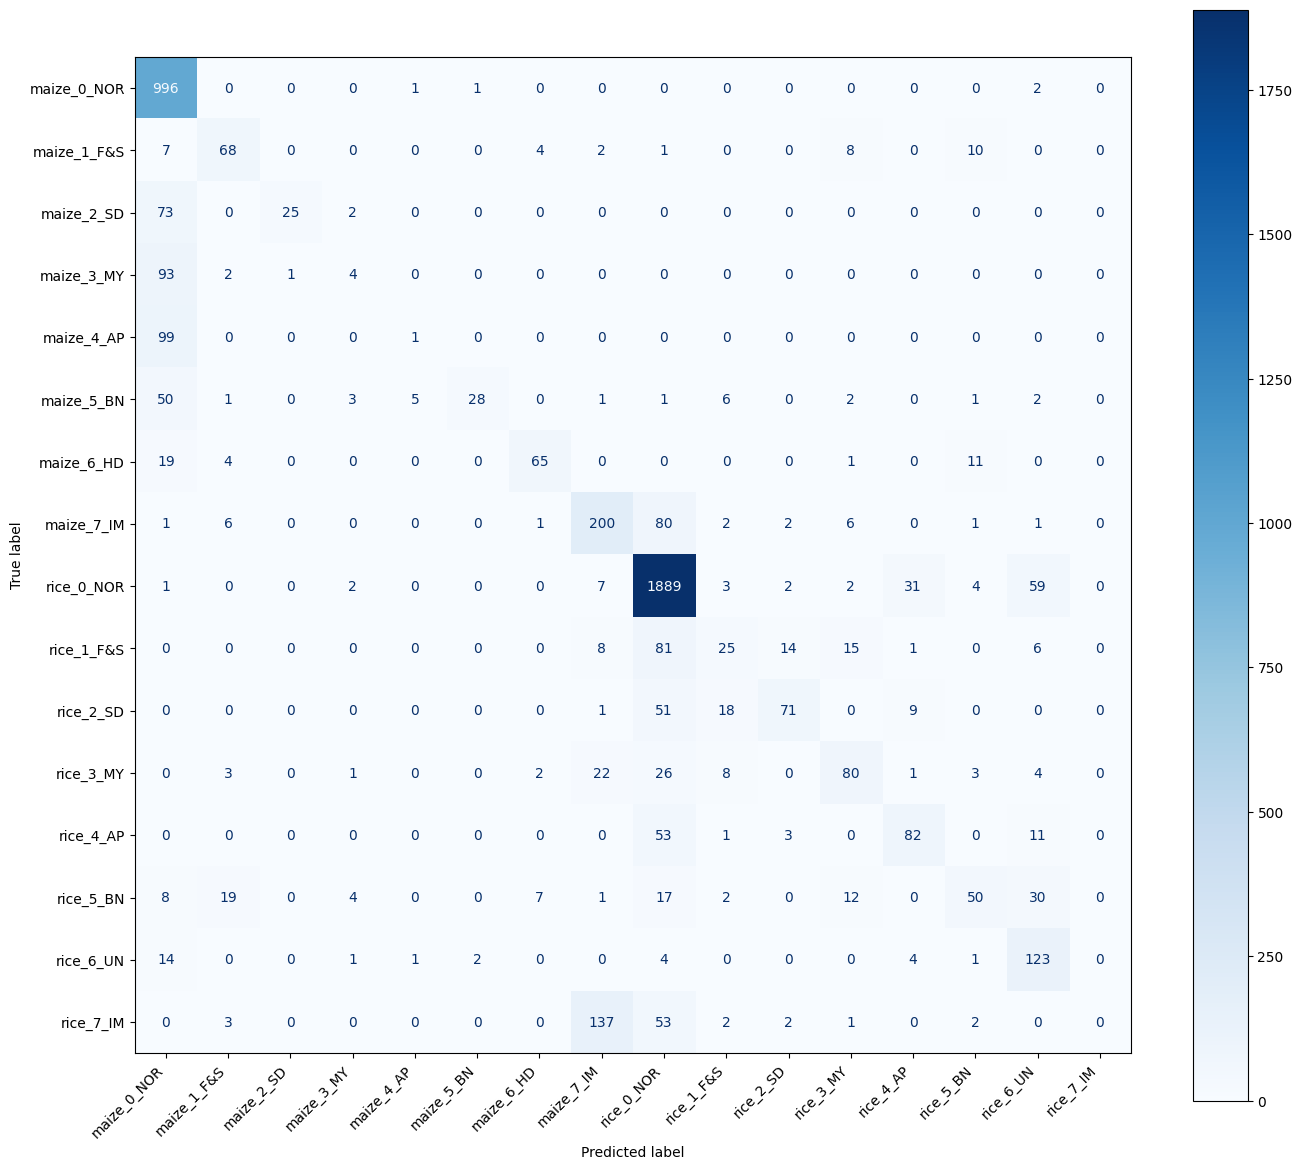


Confusion Matrix shape: (16, 16)
Number of classes: 16


In [12]:
# Display confusion matrix
cm = confusion_matrix(y_test_encoded, y_test_pred)

# Create a larger figure to show all labels clearly
fig, ax = plt.subplots(figsize=(14, 12))

# Get label names
label_names = label_encoder.classes_

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(ax=ax, cmap="Blues")

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print(f"\nConfusion Matrix shape: {cm.shape}")
print(f"Number of classes: {len(label_names)}")

### Seperate Models For Each Grain
Let us see if we can increase the performance of the logistic regression model if we have a dedicated model for each of the grain type instead of training a generalized model.


### Train the Maize Model

In [13]:
label_encoder_maize = LabelEncoder()
y_train_encoded_maize = label_encoder_maize.fit_transform(y_train_maize)

print(f"Number of classes: {len(set(y_train_maize))}")
print(f"Classes: {sorted(set(y_train_maize))}")

Number of classes: 8
Classes: ['maize_0_NOR', 'maize_1_F&S', 'maize_2_SD', 'maize_3_MY', 'maize_4_AP', 'maize_5_BN', 'maize_6_HD', 'maize_7_IM']


In [14]:
lr_model_maize = LogisticRegression(max_iter=1000, random_state=67)
lr_model_maize.fit(X_train_maize, y_train_encoded_maize)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",67
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

### Train the Rice Model

In [15]:
label_encoder_rice = LabelEncoder()
y_train_encoded_rice = label_encoder_rice.fit_transform(y_train_rice)

print(f"Number of classes: {len(set(y_train_rice))}")
print(f"Classes: {sorted(set(y_train_rice))}")

Number of classes: 8
Classes: ['rice_0_NOR', 'rice_1_F&S', 'rice_2_SD', 'rice_3_MY', 'rice_4_AP', 'rice_5_BN', 'rice_6_UN', 'rice_7_IM']


In [16]:
lr_model_rice = LogisticRegression(max_iter=1000, random_state=67)
lr_model_rice.fit(X_train_rice, y_train_encoded_rice)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",67
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

### Test Both the models

In [17]:
print(
    "Accuracy of the Rice Model: ",
    lr_model_rice.score(X_train_rice, y_train_encoded_rice),
)

Accuracy of the Rice Model:  0.8213696073505132


In [18]:
print(
    "Accuracy of the Maize model: ",
    lr_model_maize.score(X_train_maize, y_train_encoded_maize),
)

Accuracy of the Maize model:  0.8096491228070175


Let's test the Models using the test set

In [19]:
y_test_encoded_maize = label_encoder_maize.fit_transform(y_test_maize)
y_test_encoded_rice = label_encoder_rice.fit_transform(y_test_rice)

In [20]:
print(
    "Accuracy of the Rice Model: ",
    lr_model_rice.score(X_test_rice, y_test_encoded_rice),
)

Accuracy of the Rice Model:  0.8070967741935484


In [21]:
print(
    "Accuracy of the Maize Model: ",
    lr_model_maize.score(X_test_maize, y_test_encoded_maize),
)

Accuracy of the Maize Model:  0.8
